In [3]:
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d nafishamoin/bangladeshi-crops-disease-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 6.43G/6.45G [01:04<00:00, 61.0MB/s]
100% 6.45G/6.45G [01:04<00:00, 107MB/s] 


In [ ]:
!unzip /content/bangladeshi-crops-disease-dataset.zip

In [9]:
!mkdir /content/CropDisease/WheatDisease/Wheat___Brown_Rust

In [7]:
!mkdir WheatDisease
!mv /content/CropDisease/Crop___DIsease/Wheat___Brown_Rust /content/CropDisease/WheatDisease
!mv /content/CropDisease/Crop___DIsease/Wheat___Healthy /content/CropDisease/WheatDisease
!mv /content/CropDisease/Crop___DIsease/Wheat___Yellow_Rust /content/CropDisease/WheatDisease


In [71]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model


In [26]:
batch_size = 32
data_path = "/content/CropDisease/WheatDisease"
num_classes = 3
num_epochs = 10

In [12]:
Image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2
)


train_generator = Image_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training'
)


validation_generator = Image_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation'
)


Found 3026 images belonging to 3 classes.
Found 755 images belonging to 3 classes.


In [15]:
train_generator.class_indices

{'Wheat___Brown_Rust': 0, 'Wheat___Healthy': 1, 'Wheat___Yellow_Rust': 2}

In [27]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for fine-tuning
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)  # Replace 'num_classes' with the number of classes in your dataset

# Create the final model for fine-tuning
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [29]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/10
95/95 [==============================] - 119s 889ms/step - loss: 0.2333 - accuracy: 0.9161 - val_loss: 0.1421 - val_accuracy: 0.9417
Epoch 2/10
95/95 [==============================] - 92s 968ms/step - loss: 0.0425 - accuracy: 0.9865 - val_loss: 0.0706 - val_accuracy: 0.9735
Epoch 3/10
95/95 [==============================] - 84s 886ms/step - loss: 0.0428 - accuracy: 0.9855 - val_loss: 0.1922 - val_accuracy: 0.9298
Epoch 4/10
95/95 [==============================] - 85s 895ms/step - loss: 0.0468 - accuracy: 0.9828 - val_loss: 0.1852 - val_accuracy: 0.9285
Epoch 5/10
95/95 [==============================] - 83s 874ms/step - loss: 0.0230 - accuracy: 0.9911 - val_loss: 0.0510 - val_accuracy: 0.9841
Epoch 6/10
95/95 [==============================] - 83s 878ms/step - loss: 0.0180 - accuracy: 0.9941 - val_loss: 0.0515 - val_accuracy: 0.9868
Epoch 7/10
95/95 [==============================] - 82s 861ms/step - loss: 0.0189 - accuracy: 0.9934 - val_loss: 0.0384 - val_accuracy: 0.986

In [30]:
!mkdir /content/drive/MyDrive/SIH-Models

In [31]:
!mkdir /content/drive/MyDrive/SIH-Models/Wheat

In [32]:

# Save the fine-tuned model for later use
model.save('/content/drive/MyDrive/SIH-Models/Wheat/wheat_mobilenetv2.h5')

Plots saved as '/content/drive/MyDrive/SIH-Models/Wheat/train and loss'


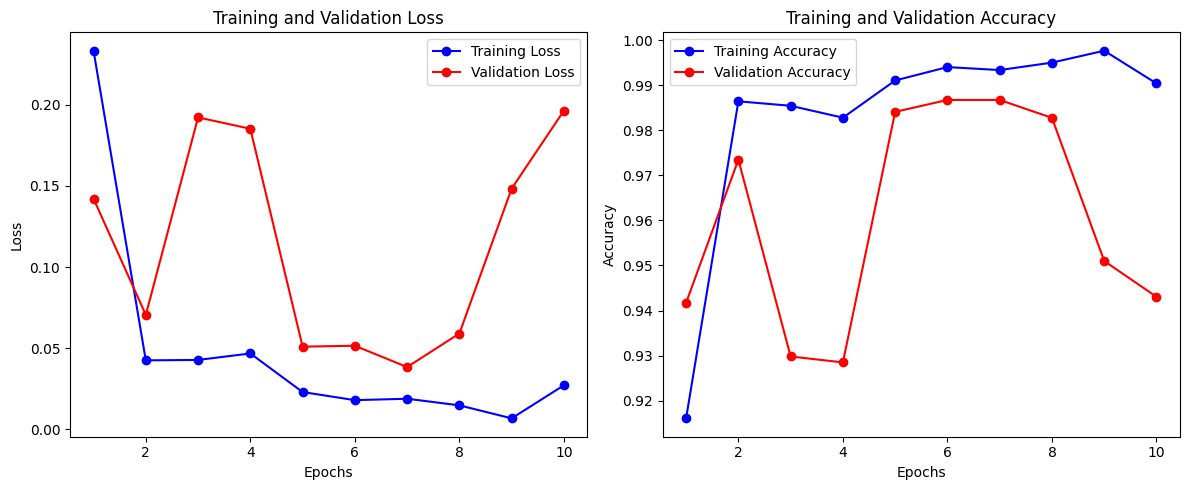

In [33]:
import os
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history, save_dir=None, filename=None):
    # Extract the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save the figure if save_dir and filename are provided
    if save_dir and filename:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path)
        print(f"Plots saved as '{save_path}'")

    plt.show()

plot_loss_and_accuracy(history ,"/content/drive/MyDrive/SIH-Models/Wheat", "train and loss" )

In [52]:
model.evaluate(validation_generator)

24/24 [==============================] - 13s 538ms/step - loss: 0.1926 - accuracy: 0.9483


[0.19263911247253418, 0.948344349861145]

In [61]:

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i in range(len(validation_generator)):
    true_labels = validation_generator[i][1]
    y_true.extend(true_labels)

    preds = model.predict(validation_generator[i][0])

    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)




1/1 [==============================] - 0s 51ms/step


In [66]:
y_true = np.argmax(y_true , axis = 1)

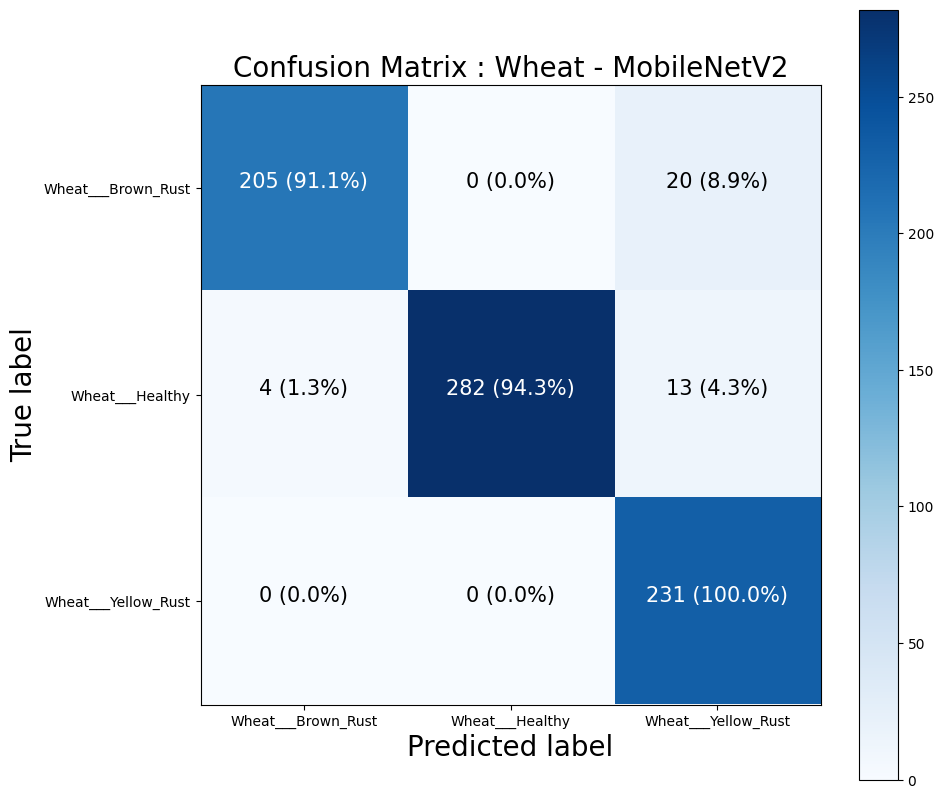

In [97]:
import itertools
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred )
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = ['Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Wheat - MobileNetV2",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
plt.savefig('/content/drive/MyDrive/SIH-Models/Wheat/Model-CM')

In [68]:
from sklearn.metrics import classification_report

print(classification_report(y_true , y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       225
           1       1.00      0.94      0.97       299
           2       0.88      1.00      0.93       231

    accuracy                           0.95       755
   macro avg       0.95      0.95      0.95       755
weighted avg       0.96      0.95      0.95       755



## 2. Float16 Qauntized

In [72]:

# Load your trained Keras model
keras_model = load_model('/content/drive/MyDrive/SIH-Models/Wheat/wheat_mobilenetv2.h5')  # Replace with your model path

# Convert the Keras model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/SIH-Models/Wheat/wheat_mobilenetv2.tflite', 'wb') as f:
    f.write(tflite_model)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/SIH-Models/Wheat/wheat_mobilenetv2.tflite')
interpreter.allocate_tensors()

# Quantization using float16
converter_float16 = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter_float16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_float16.target_spec.supported_types = [tf.float16]
tflite_model_float16 = converter_float16.convert()

# Save the float16 quantized TFLite model
with open('/content/drive/MyDrive/SIH-Models/Wheat/wheat_mobilenetv2_float16.tflite', 'wb') as f:
    f.write(tflite_model_float16)

In [90]:
import numpy as np

# Initialize lists to store test images and labels
test_imgs = []
test_labels = []

# Loop through the test generator to collect images and labels
for _ in range(len(validation_generator)):
    batch = validation_generator.next()  # Get the next batch from the iterator
    batch_images, batch_labels = batch  # Extract images and labels from the batch

    # Append the batch of images and labels to the respective lists
    test_imgs.extend(batch_images)
    test_labels.extend(batch_labels)

# Convert the lists to NumPy arrays
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

In [92]:
TF_LITE_MODEL_FILE_NAME = "/content/drive/MyDrive/SIH-Models/Wheat/wheat_mobilenetv2_float16.tflite"

In [93]:

interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 3]
Output Type: <class 'numpy.float32'>


In [94]:

interpreter.resize_tensor_input(input_details[0]['index'], (755, 224,224,3 ))
interpreter.resize_tensor_input(output_details[0]['index'], (755, 3))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [755 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [755   3]
Output Type: <class 'numpy.float32'>


In [95]:

interpreter.set_tensor(input_details[0]['index'], test_imgs)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (755, 3)


In [99]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(test_labels , axis=1) , prediction_classes))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       225
           1       1.00      0.92      0.96       299
           2       0.85      1.00      0.92       231

    accuracy                           0.94       755
   macro avg       0.94      0.94      0.94       755
weighted avg       0.95      0.94      0.94       755



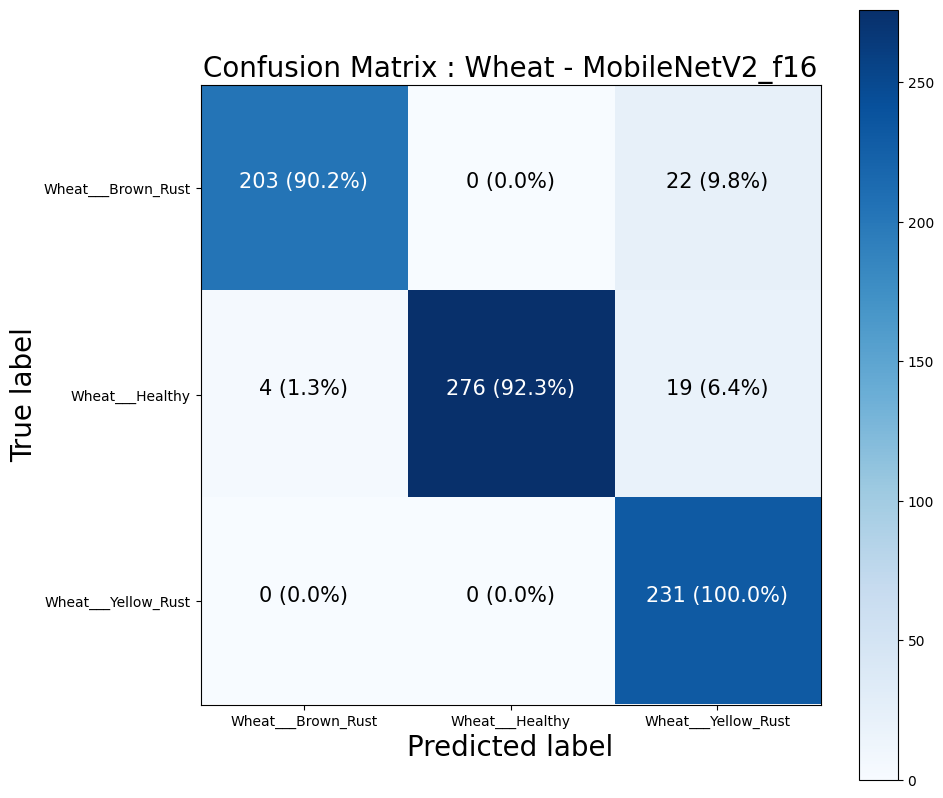

In [101]:
figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(test_labels , axis=1) , prediction_classes)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = ['Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Wheat - MobileNetV2_f16",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
plt.savefig('/content/drive/MyDrive/SIH-Models/Wheat/Modelfloat16-CM')

## 2. Int8 Qauntized Model

In [102]:

# Load your trained Keras model in .h5 format
keras_model = load_model("/content/drive/MyDrive/SIH-Models/Wheat/wheat_mobilenetv2.h5")  # Replace with your model path

# Create the TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.int8]


generator = Image_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation'
)

num_calibration_steps = 100
def representative_data_gen():
    for batch_idx in range(num_calibration_steps):
        batch = generator.next()  # Get the next batch
        yield [batch[0]]  # Yield the batch inputs

# Set the representative dataset using the generator function
converter.representative_dataset = representative_data_gen

# Convert the model to quantized TFLite format
tflite_model_quantized = converter.convert()

# Save the quantized TFLite model
with open('/content/drive/MyDrive/SIH-Models/Wheat/wheat_mobilenetv2_int8.tflite', 'wb') as f:
    f.write(tflite_model_quantized)

Found 755 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [103]:
TF_LITE_MODEL_FILE_NAME = "/content/drive/MyDrive/SIH-Models/Wheat/wheat_mobilenetv2_int8.tflite"

In [104]:

interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 3]
Output Type: <class 'numpy.float32'>


In [105]:

interpreter.resize_tensor_input(input_details[0]['index'], (755, 224,224,3 ))
interpreter.resize_tensor_input(output_details[0]['index'], (755, 3))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [755 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [755   3]
Output Type: <class 'numpy.float32'>


In [106]:

interpreter.set_tensor(input_details[0]['index'], test_imgs)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (755, 3)


In [107]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(test_labels , axis=1) , prediction_classes))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       225
           1       1.00      0.95      0.97       299
           2       0.92      1.00      0.96       231

    accuracy                           0.97       755
   macro avg       0.97      0.97      0.97       755
weighted avg       0.97      0.97      0.97       755



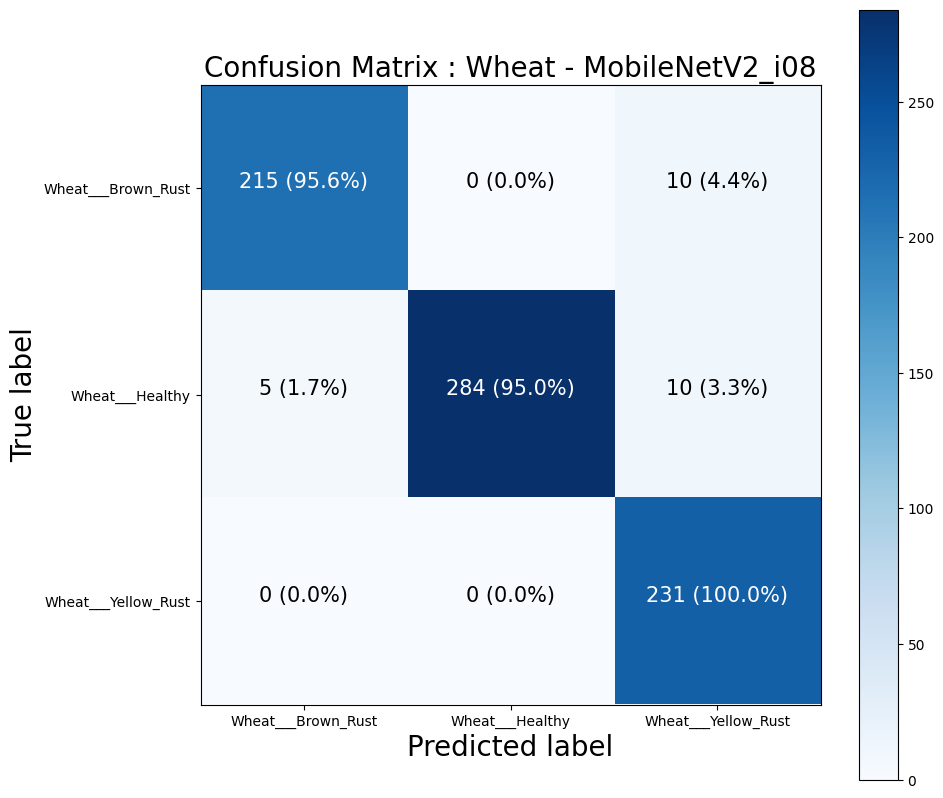

In [108]:
figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(test_labels , axis=1) , prediction_classes)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = ['Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Wheat - MobileNetV2_i08",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
plt.savefig('/content/drive/MyDrive/SIH-Models/Wheat/Modelint8-CM')

---